## 1 Data and package import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
'''
https://www.kaggle.com/code/bandiatindra/telecom-churn-prediction/input

'''

data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2 Data Inspection

### 2.1 Checking data types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.2 Transforming data

In [7]:
#Change values 0 and 1 to Yes and No in SeniorCitizen for consistent scaling
data['SeniorCitizen'] = data['SeniorCitizen'].map({1:'Yes',0:'No'})

#Change type of TotalCharges from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

### 2.3 Checking levels in categorical variables

In [8]:
for col in data.columns[1:]:
    if data[col].dtype == 'object':
        print(f'{col} {data[col].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


### 2.4 Checking missing values

In [9]:
#Check for NA´s
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
''' 
Na's in TotalCharges will replaced by MonthlyCharges times tenure -> Reason: see section 3.5
'''
data['TotalCharges'].fillna(data['MonthlyCharges']*data['tenure'],inplace=True)

### 2.5 Checking duplicates

In [11]:
data.duplicated().sum()

0

### 2.6 Delete reduntant variables

In [12]:
#Delete customerID - reduntant variable
data = data.drop('customerID',axis=1)

## 3 Exploratory data analysis

### 3.1 Churn Rate

In [13]:
#Total Churn Rate
(data[data.Churn == 'Yes']['Churn'].count() / len(data)).round(2)

0.27

### 3. 2 Distribution of churn among tenure and contract types

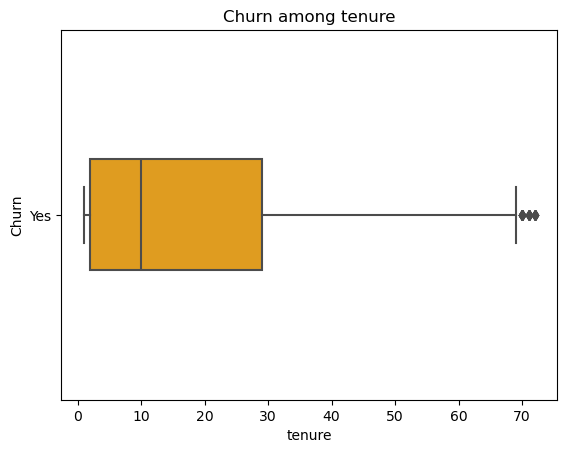

In [14]:
sns.boxplot(data=data[data.Churn == 'Yes'],y='Churn',x='tenure',color='orange',width=0.3)
plt.title('Churn among tenure')
plt.show()

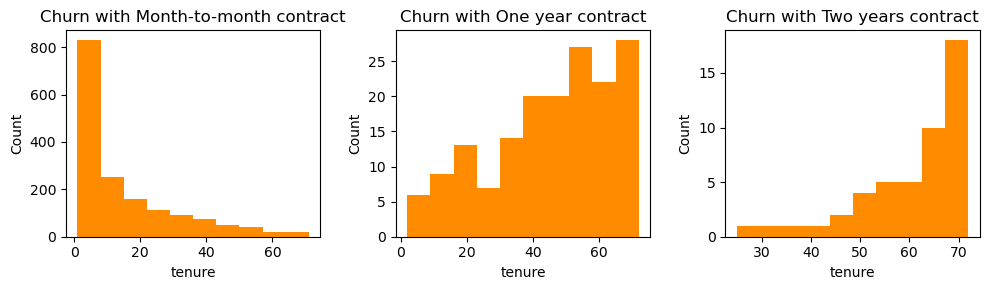

In [15]:
#Distribution of churns among tenure
def churn_rate (contract):
    return data[(data.Contract == contract) & (data.Churn == 'Yes')]['tenure']

month_to_month = churn_rate('Month-to-month')
one_year = churn_rate('One year')
two_years = churn_rate('Two year')


fig, ax = plt.subplots(ncols=3,figsize=(10,3))

ax[0].hist(month_to_month,color='darkorange')
ax[0].set_title('Churn with Month-to-month contract')
ax[0].set_xlabel('tenure')
ax[0].set_ylabel('Count')

ax[1].hist(one_year,color='darkorange')
ax[1].set_title('Churn with One year contract')
ax[1].set_xlabel('tenure')
ax[1].set_ylabel('Count')

ax[2].hist(two_years,color='darkorange')
ax[2].set_title('Churn with Two years contract')
ax[2].set_xlabel('tenure')
ax[2].set_ylabel('Count')

plt.tight_layout()

In [16]:
#Min,Max,Mean,Median contract types
contract_types = ('Month-to-month','One year','Two year')

for type in contract_types:
    print(f'{type}')
    print(data[(data.Contract == type) & (data.Churn == 'Yes')]['tenure'].describe().round())

Month-to-month
count    1655.0
mean       14.0
std        16.0
min         1.0
25%         2.0
50%         7.0
75%        21.0
max        71.0
Name: tenure, dtype: float64
One year
count    166.0
mean      45.0
std       18.0
min        2.0
25%       33.0
50%       48.0
75%       59.0
max       72.0
Name: tenure, dtype: float64
Two year
count    48.0
mean     61.0
std      11.0
min      25.0
25%      56.0
50%      66.0
75%      70.0
max      72.0
Name: tenure, dtype: float64


### 3.3 Churn rate among categorical variables

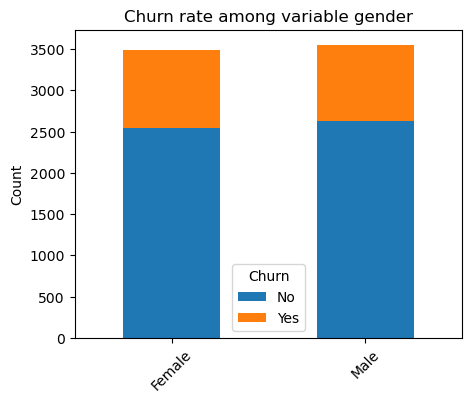

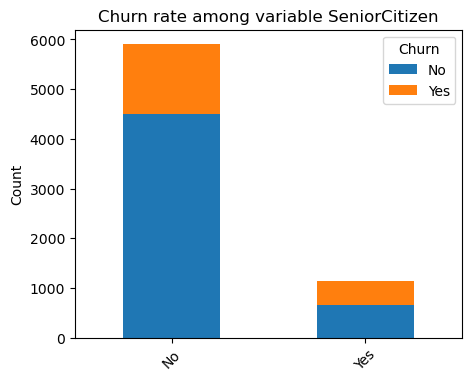

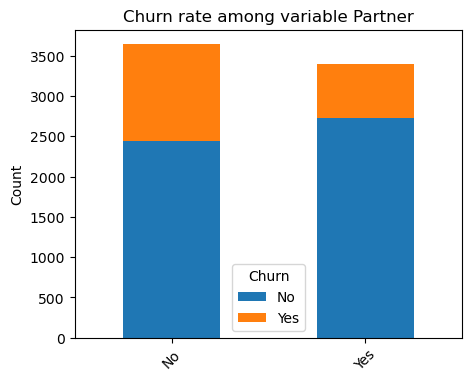

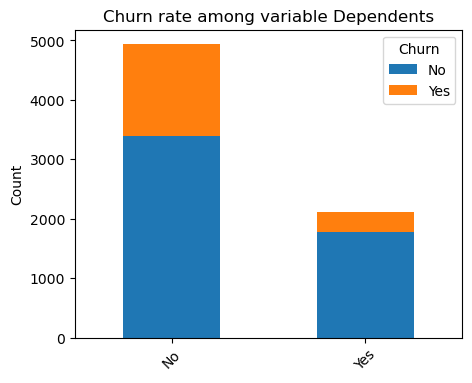

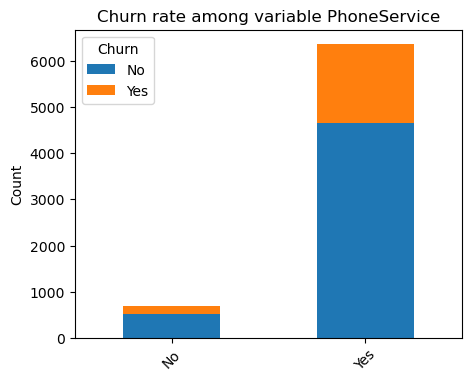

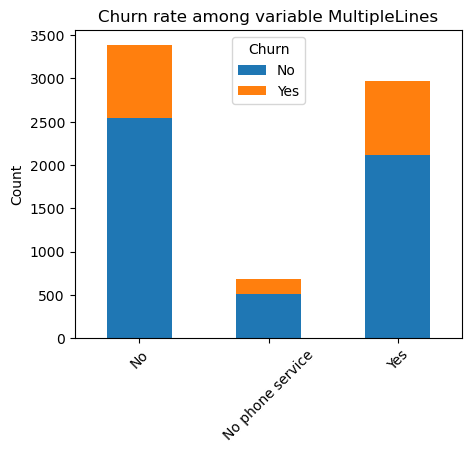

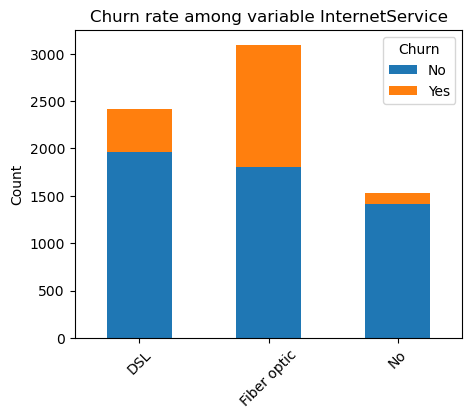

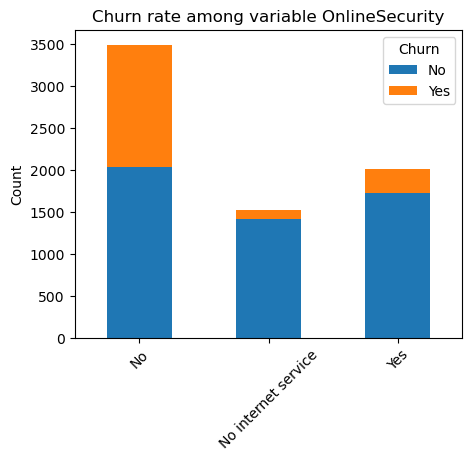

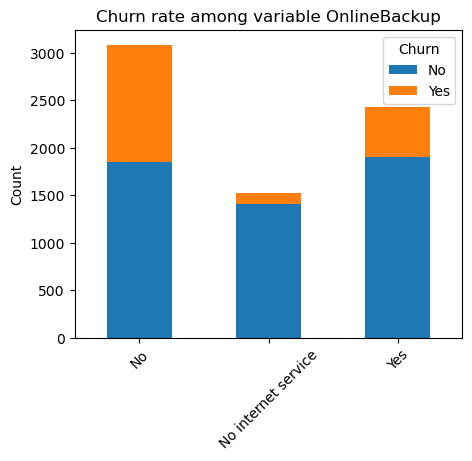

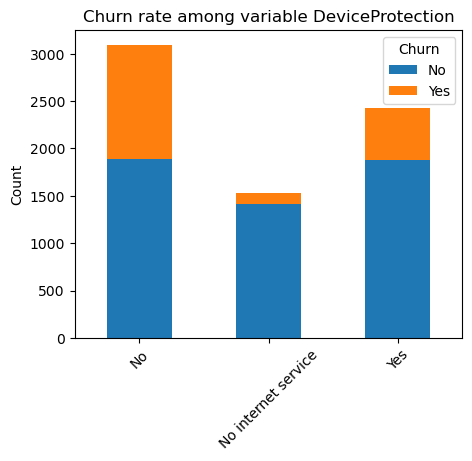

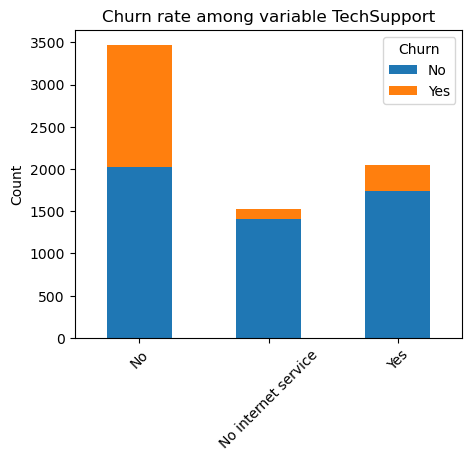

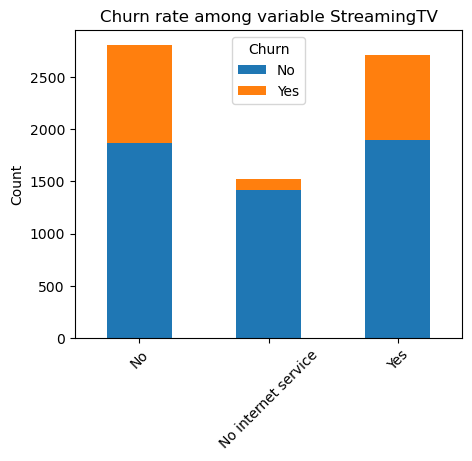

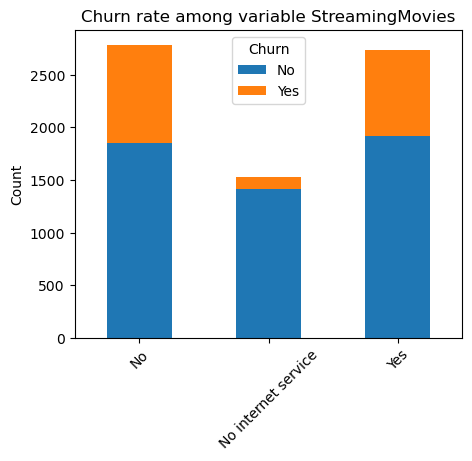

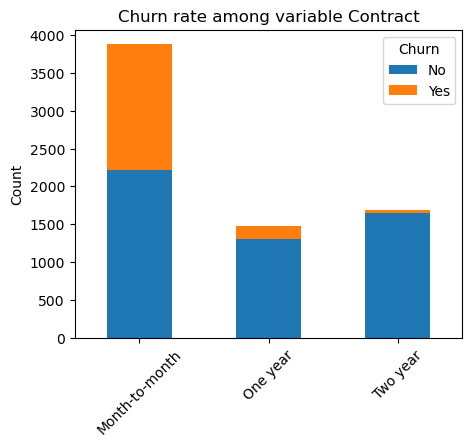

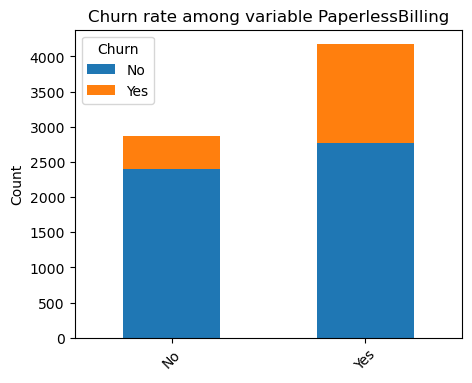

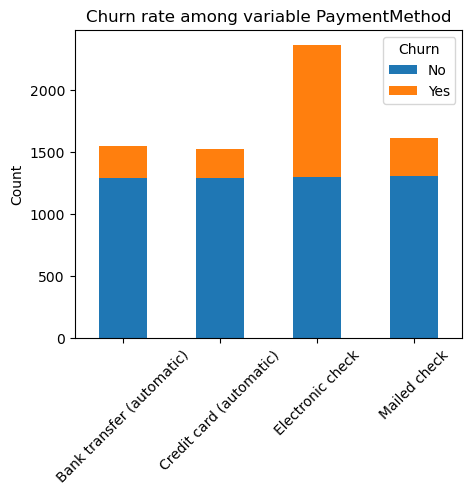

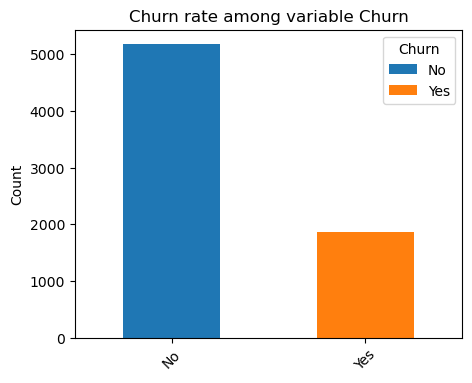

In [17]:
for var in data.columns:
    if data[var].dtype == 'object':
        churn_distribution = data.groupby([var,'Churn'])[var].value_counts()
        churn_distribution.unstack().plot.bar(stacked=True,figsize=(5,4))
        plt.title(f'Churn rate among variable {var}')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.xlabel('')
        plt.show()

### 3.5 Is total charges the product of monthlycharges*tenure?

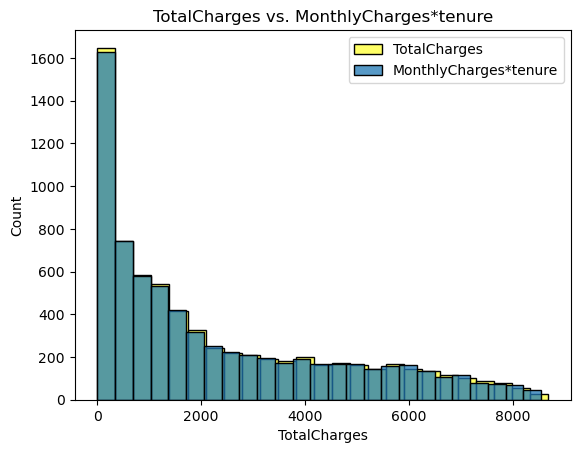

In [18]:
sns.histplot(data.TotalCharges, color='yellow',alpha=0.6,label='TotalCharges')
sns.histplot(data.MonthlyCharges*data.tenure,label='MonthlyCharges*tenure')
plt.title('TotalCharges vs. MonthlyCharges*tenure')
plt.legend()
plt.show()

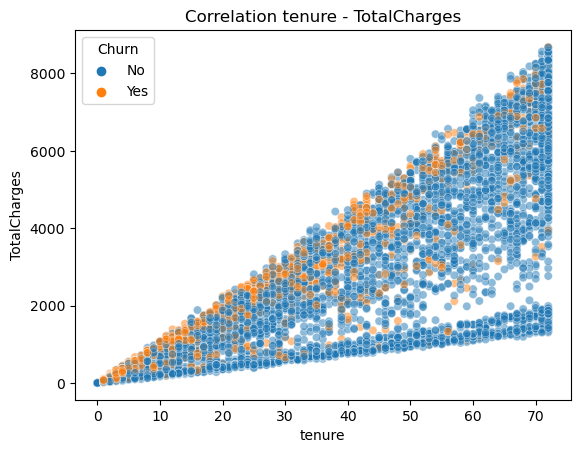

In [19]:
sns.scatterplot(data=data,x='tenure',y='TotalCharges',alpha=0.5,hue='Churn')
plt.title('Correlation tenure - TotalCharges')
plt.show()

In [20]:
#Pearson Correlation
data['tenure'].corr(data['TotalCharges'],method='pearson')

0.8261783979502421

### 3.7 Monthly and total charges among Churn

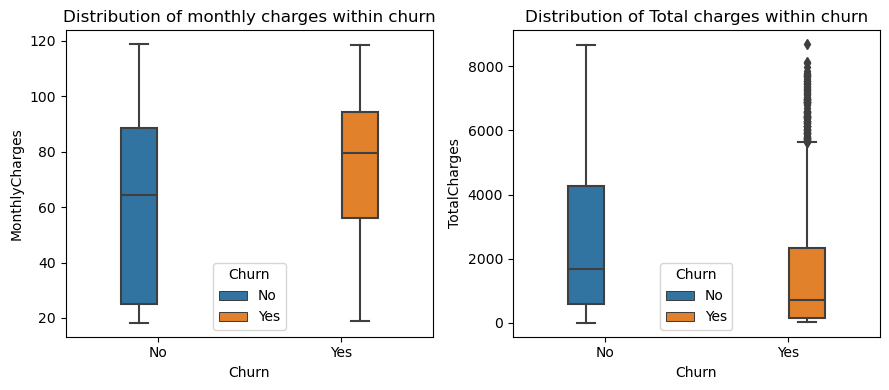

In [21]:
plt.figure(figsize=(9,4))

# Subplot 1
plt.subplot(1,2,1)
sns.boxplot(data=data,x='Churn',y='MonthlyCharges',width=0.4,hue='Churn')
plt.title('Distribution of monthly charges within churn')

# Subplot 2
plt.subplot(1,2,2)
sns.boxplot(data=data,x='Churn',y='TotalCharges',width=0.4,hue='Churn')
plt.title('Distribution of Total charges within churn')

plt.tight_layout()
plt.show()

In [22]:
#Describe MonthlyCharges among Churn
data.groupby('Churn')['MonthlyCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.27,31.09,18.25,25.10,64.43,88.4,118.75
Yes,1869.0,74.44,24.67,18.85,56.15,79.65,94.2,118.35


In [23]:
#Describe TotalCharges among Churn
data.groupby('Churn')['TotalCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,2549.91,2329.95,0.00,572.9,1679.52,4262.85,8672.45
Yes,1869.0,1531.80,1890.82,18.85,134.5,703.55,2331.30,8684.80


### 3.8 Monthly and total charges among internet services 

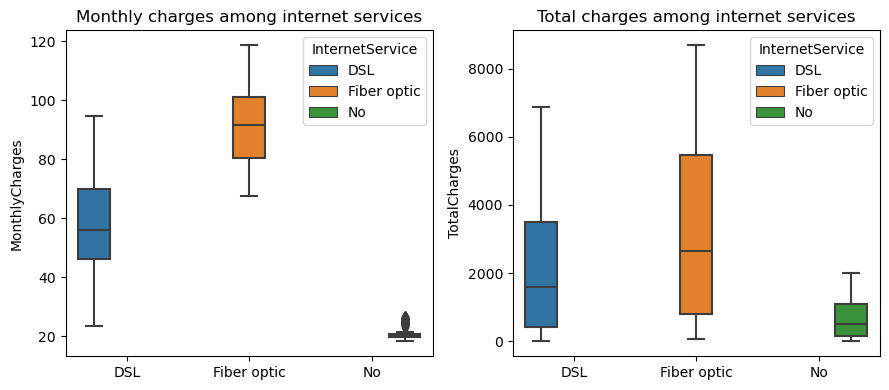

In [24]:
plt.figure(figsize=(9,4))

#Subplot 1
plt.subplot(1,2,1)
sns.boxplot(data=data,x='InternetService',y='MonthlyCharges',hue='InternetService')
plt.title('Monthly charges among internet services')
plt.xlabel('')
plt.xticks(rotation=0)

#Subplot 2
plt.subplot(1,2,2)
sns.boxplot(data=data,x='InternetService',y='TotalCharges',hue='InternetService')
plt.xlabel('')
plt.title('Total charges among internet services')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [25]:
#Description MonthlyCharges among InternetService
data.groupby('InternetService')['MonthlyCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
InternetService,,,,,,,,
DSL,2421.0,58.10,16.26,23.45,46.20,56.15,69.90,94.80
Fiber optic,3096.0,91.50,12.66,67.75,80.55,91.68,101.15,118.75
No,1526.0,21.08,2.16,18.25,19.70,20.15,20.90,26.90


In [26]:
#Description TotalCharges among InternetService
data.groupby('InternetService')['TotalCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
InternetService,,,,,,,,
DSL,2421.0,2115.41,1880.69,0.0,428.70,1596.60,3487.95,6859.05
Fiber optic,3096.0,3205.30,2570.22,68.5,795.12,2660.65,5451.38,8684.80
No,1526.0,662.60,555.63,0.0,157.82,519.20,1108.65,2006.95


In [27]:
data.to_csv('data_ml.csv')